# Project 3: Mental Health

## Notebook: EDA and Preliminary Modeling

In [27]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_regression

In [28]:
# Features of interest from the NHANES data set
feature_dict = {'demographic': {'SEQN': 'Respondent_sequence_num',
                                'RIAGENDR': 'Gender',
                                'RIDAGEYR': 'Age_at_screening',
                                'RIDRETH1': 'Race/ethnicity',
                                'DMDEDUC3': 'Education_6-19',
                                'DMDEDUC2': 'Education_20+',
                                'DMDSCHOL': 'Attending_school',
                                'DMDMARTL': 'Marital_status',
                                'INDHHIN2': 'Annual_household_income',
                                'INDFMIN2': 'Annual_family_income',
                                'INDFMPIR': 'Income_family_to_poverty'
                               },
                'depression': {'DPQ010': 'Interest_in_things',           # This section is scaled 
#                               'DPQ020': 'Down_depressed_hopeless',      # 0 - not at all
#                               'DPQ030': 'Trouble/too_much_sleeping',    # 3 - nearly every day
                               'DPQ040': 'Tired/little_energy',          # 7 - refused
                               'DPQ050': 'Poor_appetite/overeating',     # 9 - don't know
#                               'DPQ060': 'Feeling_bad',
                               'DPQ070': 'Trouble_concentrating',
                               'DPQ080': 'Moving/speaking_slow/fast',
#                               'DPQ090': 'Thoughts_of_death',
#                               'DPQ100': 'Difficulty_from_problems'
                              },
                'drug_use': {'DUQ200': 'Marijuana_ever_used',
                             'DUQ211': 'Marijuana_per_month_for_year',
                             'DUQ217': 'Marijuana_frequency',
                             'DUQ230': 'Marijuana_days/month',
                             'DUQ240': 'Cocaine/heroin/meth_ever_used',
                             'DUQ250': 'Cocaine_ever_used',
                             'DUQ272': 'Cocaine_times_used_lifespan',
                             'DUQ280': 'Cocaine_days/month',
                             'DUQ290': 'Heroin_ever_used',
                             'DUQ320': 'Heroin_days/month',
                             'DUQ330': 'Meth_ever_used',
                             'DUQ352': 'Meth_times_used_lifespan',
                             'DUQ360': 'Meth_days/month',
                             'DUQ430': 'Rehab_ever_been'
                            },
                'hospital_util': {'HUQ010': 'General_health_cond',
                                  'HUQ090': 'Mental_health_past_yr'
                                 },
                'sleep': {'SLD010H': 'Sleep_hr/night'
                         },
#                'curr_health_status': {'HSD010': 'General_health_cond',    # ended up not exporting
#                                       'HSQ470': 'Days_bad_phys_health',   # this data set
#                                       'HSQ480': 'Days_bad_mental_health',
#                                       'HSQ490': 'Inactive_days',
#                                       'HSQ496': 'Anxious_days'
#                                       },
                'physical_activity': {'PAQ605': 'Vigorous_work/activity',
                                      'PAQ610': 'Days_vigorous_work',
                                      'PAQ620': 'Moderate_work/activity',
                                      'PAQ625': 'Days_moderate_work',
                                      'PAQ635': 'Walk/bike',
                                      'PAQ640': 'Days_walk/bike',
                                      'PAQ650': 'Vigorous_recreation',
                                      'PAQ655': 'Days_vigorous_recreation',
                                      'PAQ665': 'Moderate_recreation',
                                      'PAQ670': 'Days_moderate_recreation',
                                      'PAD680': 'Mins_sedentary_activity'
                                     },
                'smoking_habits': {'SMQ040': 'Now_smoke_cigarettes'
                                  },
                'weight_height_survey': {'WHD010': 'Self_assess_height',
                                         'WHD020': 'Self_assess_weight',
                                         'WHQ030': 'Self_assess_over/underweight',
                                         'WHQ040': 'Like_to_weigh_more/less',
                                        },
                'drug_prescription': {'RXDDRUG': 'Generic_drug_name',
                                      'RXDDRGID': 'Generic_drug_code',
                                      'RXDDAYS': 'Days_taken_med',
                                      'RXDCOUNT': 'Num_prescription_taken'
                                     }
               }

                # Link for drug codes (1999-2000):
                # https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/RXQ_DRUG.htm

In [29]:
# Import the cleaned master data frame
df_master = pd.read_csv('nhanes_master_dataframe_no_duplicate.csv', index_col = 0)

df_master.head(5)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC3,DMDEDUC2,DMDSCHOL,DMDMARTL,INDHHIN2,INDFMIN2,...,RXDDRUG,RXDDRGID,RXDDAYS,RXDCOUNT,DRUGDIAGN,DRUGDIAGN_SIMP,DPQ_SUMMARY,EXERCISE_AT_ALL,BMI,DPQ_CLASS_BINARY
0,51624.0,1.0,34.0,3.0,NaN,3.0,NaN,1.0,6.0,6.0,...,DULOXETINE,d05355,730.0,3.0,1,1,10.0,0,32.277319,0
1,51628.0,2.0,60.0,4.0,NaN,3.0,NaN,2.0,3.0,3.0,...,CARVEDILOL,d03847,365.0,6.0,2,0,20.0,0,38.732782,1
2,51629.0,1.0,26.0,1.0,NaN,2.0,NaN,1.0,6.0,6.0,...,NaN,NaN,NaN,NaN,0,0,5.0,1,33.903330,0
3,51630.0,2.0,49.0,3.0,NaN,4.0,NaN,6.0,7.0,7.0,...,ACYCLOVIR,d00001,243.0,5.0,2,0,3.0,0,29.754957,0
4,51633.0,1.0,80.0,3.0,NaN,4.0,NaN,1.0,4.0,4.0,...,TAMSULOSIN,d04121,365.0,1.0,2,0,0.0,1,23.731674,0


In [30]:
# Generate a general dataframe to start EDA and modeling

# Add columns from the dictionary key 'depression' into a new dataframe
df = df_master[feature_dict['depression'].keys()]
df = df.rename(columns=feature_dict['depression'])

# Add diagnosis column as the first column
diagnosis = df_master['DRUGDIAGN_SIMP']
df.insert(0, 'Diagnosis', diagnosis)

df.head(5)

,Diagnosis,Interest_in_things,Tired/little_energy,Poor_appetite/overeating,Trouble_concentrating,Moving/speaking_slow/fast
0,1,2.0,1.0,1.0,1.0,1.0
1,0,3.0,3.0,2.0,2.0,3.0
2,0,0.0,0.0,0.0,0.0,2.0
3,0,1.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0


In [31]:
# # Testing a bunch of features
# df['Num_prescription_taken'] = df_master['RXDCOUNT']
# df['Gender'] = df_master['RIAGENDR']
# df['Ratio_income_to_fam'] = df_master['INDFMPIR']
# df['Marijuana_days/month'] = df_master['DUQ230']
# df['Cocaine_days/month'] = df_master['DUQ280']
# df['General_good_health'] = df_master['HUQ010'] #Scale 1-5 (1 being excellent, 5 being poor)
# df['Mental_health_past_yr'] = df_master['HUQ090']
# df['Sleep_hr/night'] = df_master['SLD010H']
# df['Mins_sedentary_activity'] = df_master['PAD680'] #Minutes sitting per day, excluding sleeping
# df['Age_at_screening'] = df_master['RIDAGEYR']
# df['Race/ethnicity'] = df_master['RIDRETH1']
# df['Education_6-19'] = df_master['DMDEDUC3']
# df['Education_20+'] = df_master['DMDEDUC2']
# df['Marital_status'] = df_master['DMDMARTL']

# df.sample(20)

In [32]:
# Add additional SPECIFIC FEATURES
df['Ratio_income_to_fam'] = df_master['INDFMPIR']
#df['General_good_health'] = df_master['HUQ010'] #Scale 1-5 (1 being excellent, 5 being poor)
df['Sleep_hr/night'] = df_master['SLD010H']
df['Mins_sedentary_activity'] = df_master['PAD680'] #Minutes sitting per day, excluding sleeping
df['Age_at_screening'] = df_master['RIDAGEYR']
df['Race/ethnicity'] = df_master['RIDRETH1']
# df['Mental_health_past_yr'] = df_master['HUQ090']
df['Num_prescription_taken'] = df_master['RXDCOUNT']

df['Education_20+'] = df_master['DMDEDUC2']
df['Marital_status'] = df_master['DMDMARTL']

df['Exercise'] = df_master['EXERCISE_AT_ALL']
df['BMI'] = df_master['BMI']
df['Smoking_frequency'] = df_master['SMQ040']

#df['Marijuana_days/month'] = df_master['DUQ230']
#df.loc[(pd.isna(df['Marijuana_days/month'])), 'Marijuana_days/month'] = 99

# df['Cocaine_days/month'] = df_master['DUQ280']
# df.loc[(pd.isna(df['Cocaine_days/month'])), 'Cocaine_days/month'] = 99

#df['Anti-depressants'] = df_master['DRUGDIAGN_SIMP']

df.shape

(25228, 17)

In [33]:
# Create a list of features by collecting column names (dropping first col, 'Diagnosis')
features = df.drop('Diagnosis', axis = 1)

# Saving feature names for later use; we can call feature_list if needed
feature_list = list(features.columns)

feature_list

['Interest_in_things',
 'Tired/little_energy',
 'Poor_appetite/overeating',
 'Trouble_concentrating',
 'Moving/speaking_slow/fast',
 'Ratio_income_to_fam',
 'Sleep_hr/night',
 'Mins_sedentary_activity',
 'Age_at_screening',
 'Race/ethnicity',
 'Num_prescription_taken',
 'Education_20+',
 'Marital_status',
 'Exercise',
 'BMI',
 'Smoking_frequency']

In [34]:
# Check how many 1's and 0's exist in 'Diagnosis'
df['Diagnosis'].value_counts()

0    22740
1     2488
Name: Diagnosis, dtype: int64

### Checking Collinear Features

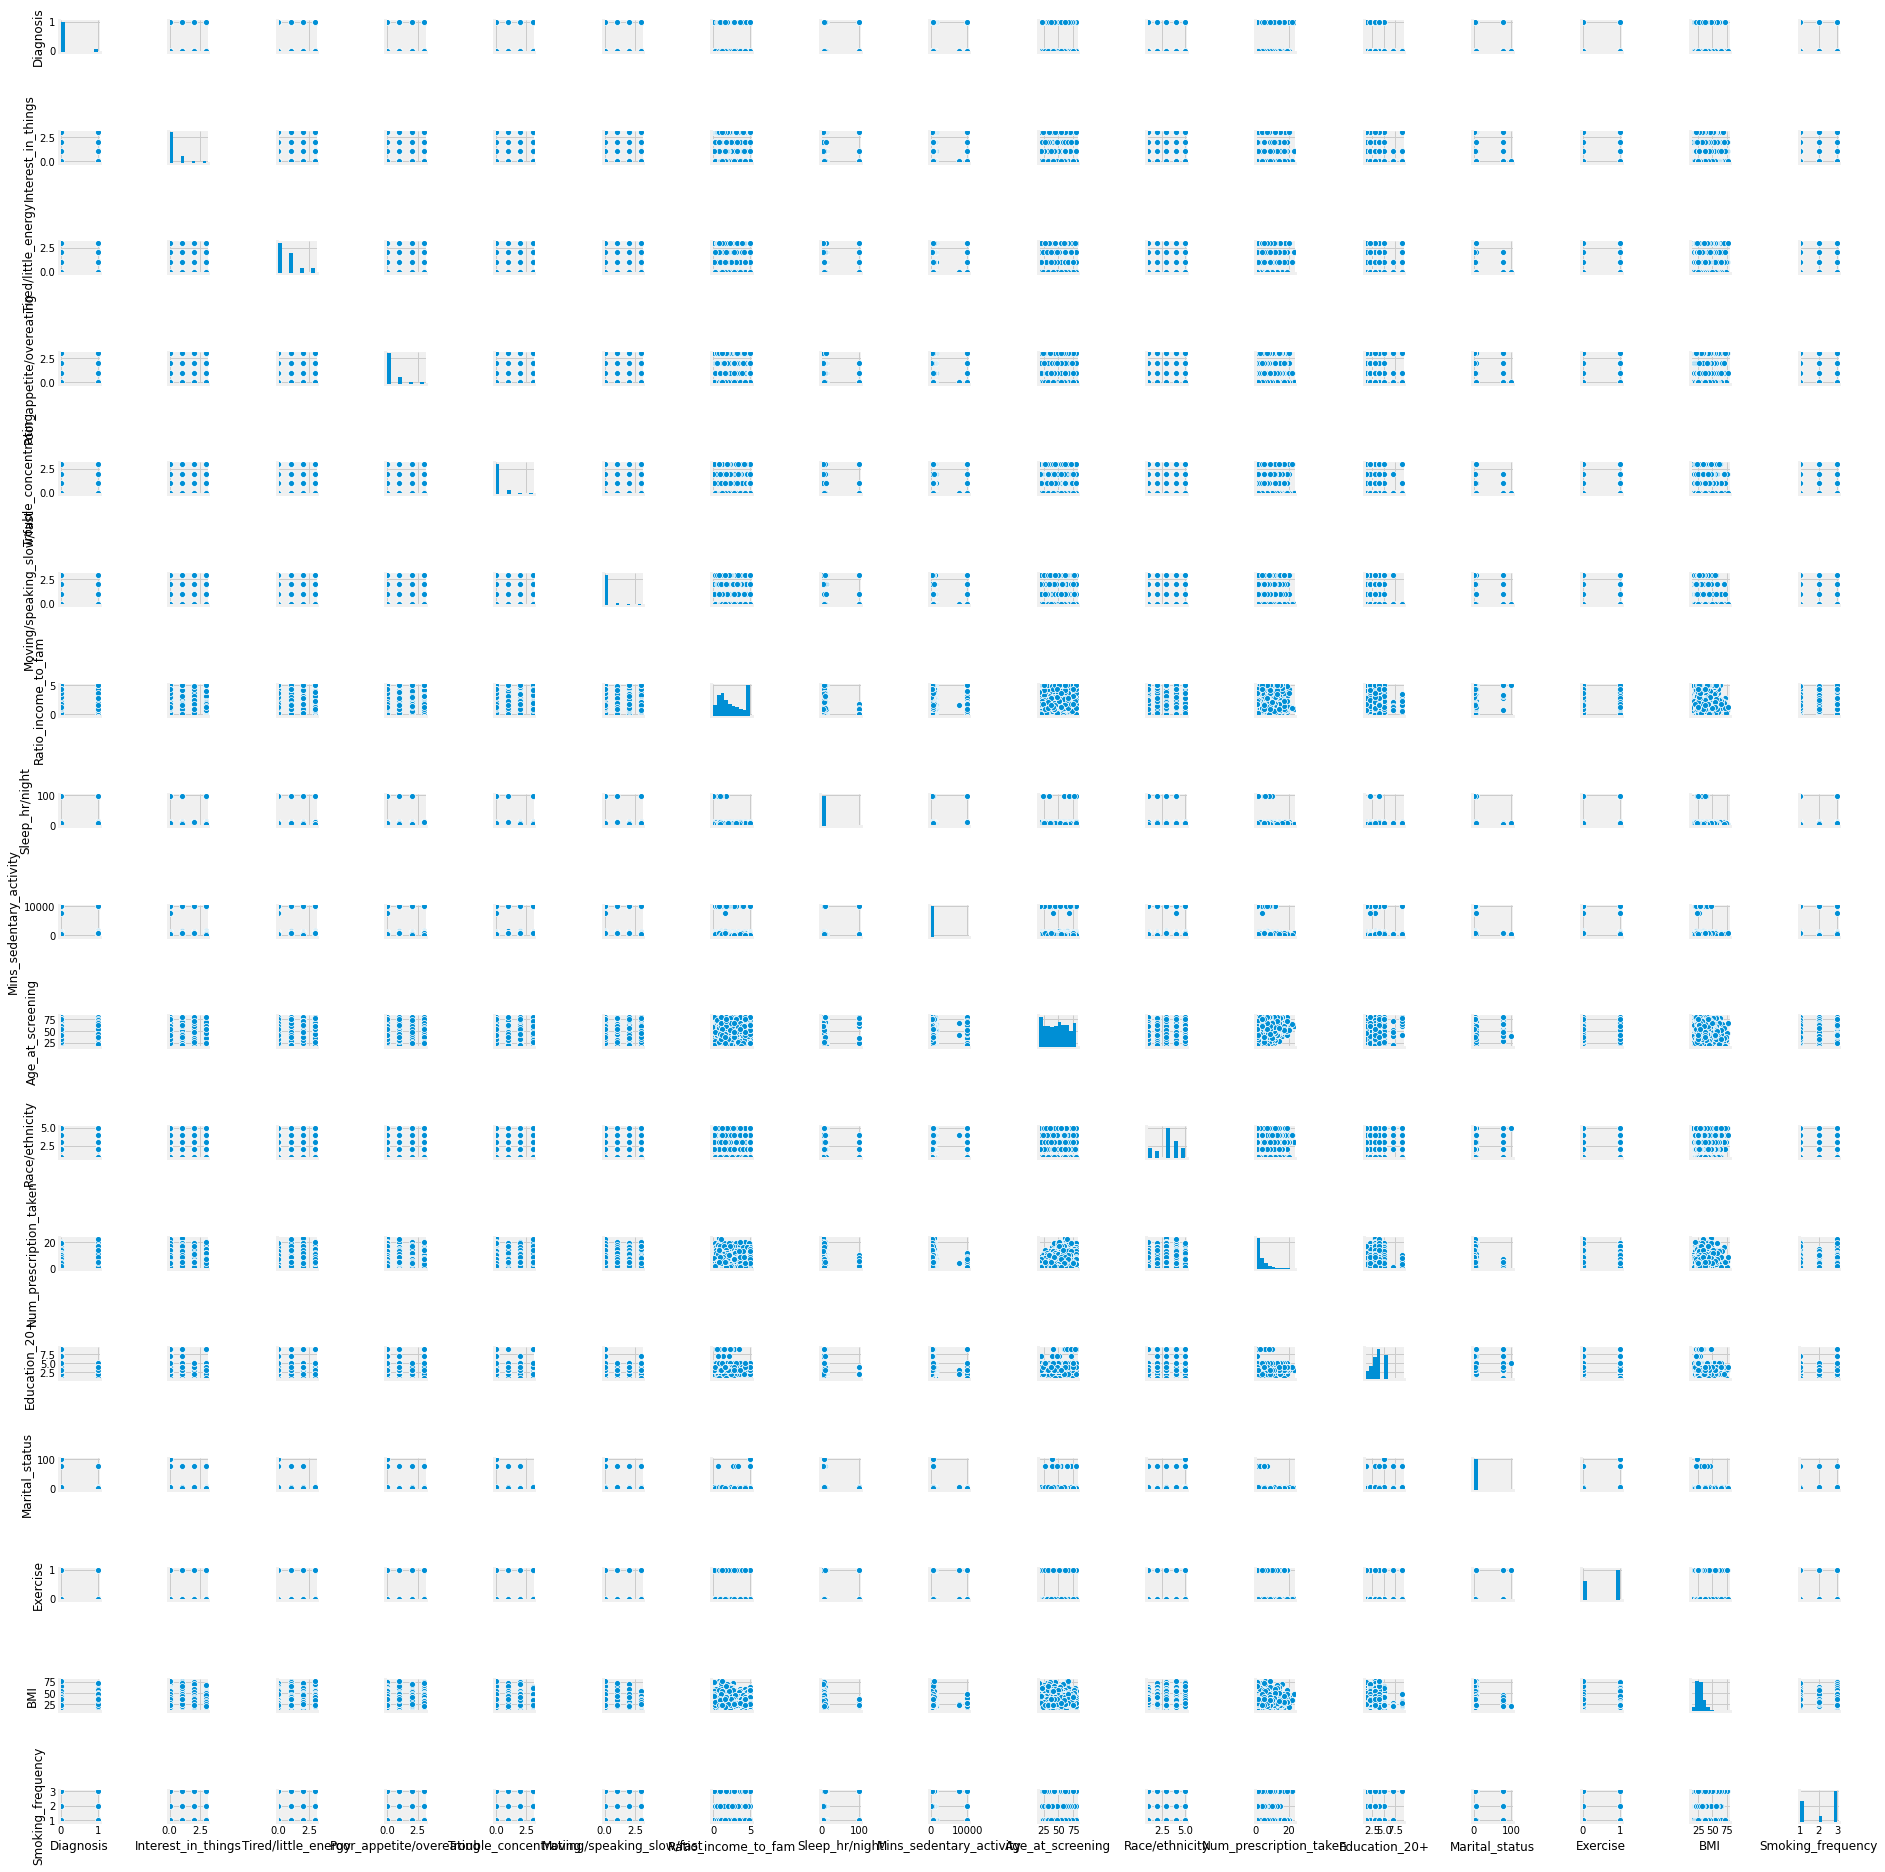

In [35]:
# Create a pair plot to examine correlations
sns.pairplot(df, height = 1.5, aspect = 1);

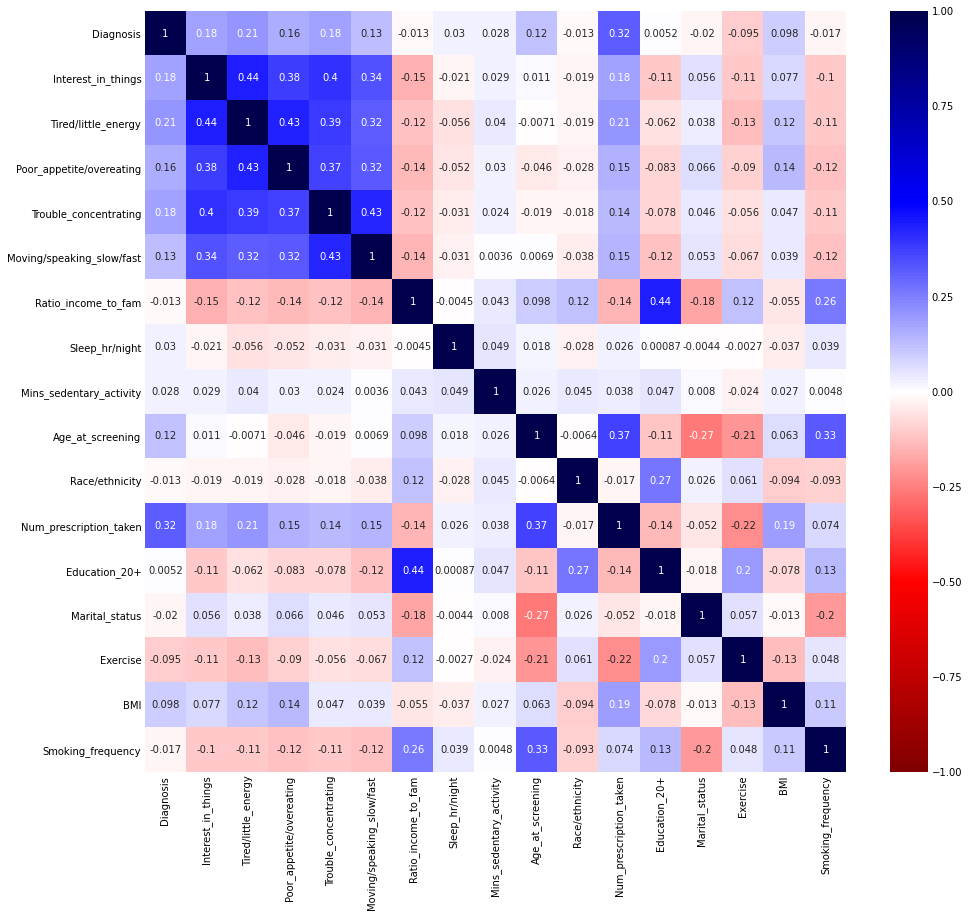

In [41]:
# Create a heat map to quantify correlations
fig = plt.subplots(figsize=(14,14))
sns.heatmap(df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1)

plt.savefig('images/heatmap.png', bbox_inches = 'tight', dpi = 300)

### Create X (Features) and y (target variable)

In [10]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:],
                                                    df.iloc[:, 0], 
                                                    test_size = 0.2,
                                                    random_state = 20)

print('Features Shape (X):', X.shape)
print('Labels Shape (y):', y.shape)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Features Shape (X): (49693, 24)
Labels Shape (y): (49693,)
Training Features Shape: (39754, 24)
Training Labels Shape: (39754,)
Testing Features Shape: (9939, 24)
Testing Labels Shape: (9939,)


### Undersample or Oversample: Choose Oversample

Choose to **oversample** because:
1. It will not be computationally expensive.
2. I do not want to lose data.

In [11]:
import imblearn.over_sampling
from collections import Counter

In [12]:
# ros = RandomOverSampler(random_state = 42)
# X_train_resampled, y_train_resampled = ros.fit_sample(X_train, y_train)
# X_test_resampled, y_test_resampled = ros.fit_sample(X_test, y_test)

# Counter(y_test_resampled)

In [13]:
# Setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 10, 0 : n_neg}

In [14]:
# Randomly oversample positive samples: create 10x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_train_resample, y_train_resample = ROS.fit_sample(X_train, y_train)

### Undersample or Oversample: Checking Undersample (Don't Run This Section)

In [15]:
import imblearn.under_sampling

In [16]:
# Setup for the ratio argument of RandomUnderSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos, 0 : n_neg}

In [17]:
# Randomly oversample positive samples: create 10x as many 
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 

X_train_resample, y_train_resample = RUS.fit_sample(X_train, y_train)

### Impute: Replacing NaN with Real Values

In [18]:
# Reference: https://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(X_train_resample)

In [19]:
X_train_resample_imp = imp.transform(X_train_resample)
X_test_imp = imp.transform(X_test)

### Feature Importance Using Random Forest Classifier

In [20]:
# Reference: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# Decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from matplotlib import pyplot

In [21]:
# Define dataset
# X, y = make_classification(n_samples = 20000,
#                            n_features = len(df.iloc[:, 1:].columns),
#                            n_informative = 10,
#                            n_redundant = 10,
#                            random_state = 10)

# Define the model
model = RandomForestClassifier()

# Fit the model
model.fit(X_train_resample_imp, y_train_resample)

# Get importance
importance = pd.Series(model.feature_importances_, index = df.iloc[:, 1:].columns)
#importance = model.feature_importances_

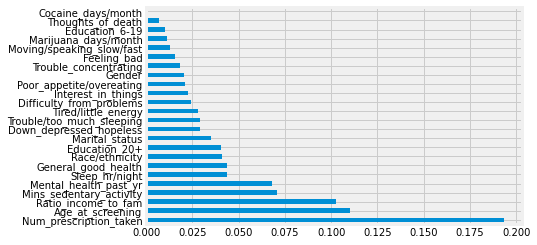

In [22]:
importance.nlargest(len(df.iloc[:, 1:].columns)).plot(kind = 'barh')
plt.show()

### Random Forest Classifier

In [23]:
rf_class = RandomForestClassifier(n_estimators = 100,
                                  max_features = 10)

In [24]:
rf_class.fit(X_train_resample_imp, y_train_resample)

RandomForestClassifier(max_features=10)

In [25]:
print("Training: {:6.2f}%".format(100*rf_class.score(X_train_resample_imp, y_train_resample)))
print("Test set: {:6.2f}%".format(100*rf_class.score(X_test_imp, y_test)))

Training:  99.98%
Test set:  93.40%


In [26]:
# Confusion matrix of random forest
#  [true (0)], [false (1)]
# [false (0)], [true (1)]

confusion_matrix(y_test, rf_class.predict(X_test_imp))

array([[8995,  158],
       [ 498,  288]])

In [27]:
rf_class_confusion = confusion_matrix(y_test, rf_class.predict(X_test_imp))

# plt.figure(dpi=50)
# sns.heatmap(rf_class_confusion, cmap=plt.cm.Blues, annot=True, square=True,
#            xticklabels=df['Diagnosis'],
#            yticklabels=df['Diagnosis'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('RF Classifier Confusion Matrix');

In [28]:
# y_predict = rf_class.predict(X_test_imp)

In [29]:
# len(y_predict)